In [138]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import importlib

import methods.pilot_estimation as pilot_estimation
import methods.interpolation as interpolation
import methods.equalizer as equalizer

importlib.reload(pilot_estimation)
importlib.reload(interpolation)
importlib.reload(equalizer)

mat = scipy.io.loadmat('DataSet/DataSet3.mat')

channel = mat['Channel']
image_size = [int(i) for i in mat['ImageSize'][0]]
ofdm = mat['OFDM']

high_noise_signal = mat['HighNoise_RxSignal']
low_noise_signal = mat['LowNoise_RxSignal']
no_noise_signal = mat['NoNoise_RxSignal']

channel = { 'Name': str(channel[0][0][0][0]),
            'Length': int(channel[0][0][1][0][0]),
            'DopplerFreq': int(channel[0][0][2][0][0]),
            'CorrCoefficient': float(channel[0][0][3][0][0])}

ofdm = {'Name': str(ofdm[0][0][0][0]),
        'Bandwidth': int(ofdm[0][0][0][0].split('Mz')[0]) * 10**6,
        'SamplingFrq': int(ofdm[0][0][1][0][0]),
        'CarrierFreq': int(ofdm[0][0][2][0][0]),
        'FFTSize': int(ofdm[0][0][3][0][0]),
        'DataSubcarriers': int(ofdm[0][0][4][0][0]),
        'Modulation': str(ofdm[0][0][5][0]),
        'PilotIndices': ofdm[0][0][6][0],
        'DataIndices': ofdm[0][0][7][0],
        'FrameLen': int(ofdm[0][0][8][0][0]),
        'PilotSymbols': ofdm[0][0][9][0]}


# Usure wether 0 or 1 indexing was used in the .mat file
# I assumed 1-indexing, because MATLAB uses 1-indexing and then the zero padding is evenly distributed on both sides of the data (Except for one weird sample at 1024 (i.e 1025 in matlab))
# Update: 1-indexing produced the correct result compared to 0-indexing :)
pilot_indices = ofdm['PilotIndices'] - 1  # Convert to zero-based indexing
data_indices = ofdm['DataIndices'] - 1    # Convert to zero-based indexing

channel_length = channel['Length']
fft_size = ofdm['FFTSize']
frame_length = ofdm['FrameLen']

num_pilots = len(pilot_indices)
pilot_symbol = ofdm['PilotSymbols'][0]

corr_coeff = channel['CorrCoefficient']

In [139]:
signals = {
    'NoNoise': [100, no_noise_signal.flatten()],
    'LowNoise': [25, low_noise_signal.flatten()],
    'HighNoise': [10, high_noise_signal.flatten()]
}

In [140]:
# Pilot Channel Estimation
pilot_estimation_method = 'Naive' # 'Naive' or 'Kalman'

# Interpolation Method
interpolation_method = 'Wiener' # 'Linear' or 'Wiener'

# Equalizing Method
equalizer_method = 'ZF' # 'ZF' or 'MMSE'

In [141]:
SNR, signal = signals['NoNoise']
noise_variance = 10 ** (-SNR / 10)

In [142]:
pilot_estimation_kwargs = {'corr_coeff': corr_coeff, 'process_noise_var': 0.14, 'noise_var': noise_variance}
match pilot_estimation_method:
    case 'Naive':
        pilot_estimation_function = pilot_estimation.naive
    case 'Kalman':
        pilot_estimation_function = pilot_estimation.kalman_filter
    case _:
        raise ValueError("Invalid pilot estimation method. Choose 'Naive' or 'Kalman'.")

match interpolation_method:
    case 'Linear':
        interpolation_function = interpolation.linear
    case 'Wiener':
        interpolation_function = interpolation.wiener
    case _:
        raise ValueError("Invalid interpolation method. Choose 'Linear' or 'Wiener'.")

match equalizer_method:
    case 'ZF':
        equalizer_function = equalizer.zero_forcing
    case 'MMSE':
        equalizer_function = equalizer.mmse
    case _:
        raise ValueError("Invalid equalizer method. Choose 'ZF' or 'MMSE'.")

# Signal Structure
The signal contains 15616 samples which represents 1 frame consisting of 7 symbols. Each symbol consists of a cyclic prefix of length 160 and 2048 samples of data. Thus, each symbol has a length of 2208. With an additional cyclic prefix at the end, this results in a signal length of 7 * 2208 + 160 = 15616.

In [143]:
# Remove the cyclic prefix
prefix_length = channel_length - 1
data_length = fft_size
number_of_frames = no_noise_signal.shape[0] // ((data_length + prefix_length) * frame_length)

print(f'There are {number_of_frames} OFDM frames with {ofdm["FrameLen"]} symbols each.')

symbols = np.array([{'signal': signal[i * data_length + (i + 1) * prefix_length : (i + 1) * (data_length + prefix_length)]} for i in range(frame_length)])

print(symbols[0]['signal'])

There are 1 OFDM frames with 7 symbols each.
[ 0.83016058-0.55918544j  0.34979332-0.08425907j -1.37651483+1.24373474j
 ...  0.39768226+0.00427248j -1.43175544+0.85549944j
  0.44671996-0.38653029j]


In [144]:
# Compute the FFT for each symbol
# Note the 1/sqrt(N) scaling
for i in range(frame_length):
    symbols[i]['fft'] = np.fft.fft(symbols[i]['signal']) / np.sqrt(fft_size + prefix_length)
    
print(symbols[0]['fft'])

[ 1.32311844e-16-5.6705076e-17j -1.89016920e-16+9.4508460e-17j
  0.00000000e+00-7.5606768e-17j ...  0.00000000e+00-3.7803384e-17j
 -5.67050760e-17+9.4508460e-17j  1.13410152e-16+6.6155922e-17j]


In [145]:
all_subcarriers = np.arange(ofdm['FFTSize'])
zero_subcarriers = np.setdiff1d(all_subcarriers, np.concatenate([data_indices, pilot_indices]))

zero_samples = np.concatenate([symbols[i]['fft'][zero_subcarriers] for i in range(frame_length)])

print(f'Estimated noise variance: {np.mean(np.abs(zero_samples)**2)}')
print(f'Calculated noise variance: {noise_variance}')

Estimated noise variance: 2.4836669906813583e-32
Calculated noise variance: 1e-10


In [146]:
pilot_estimations = pilot_estimation_function(np.array([symbols[i]['fft'] for i in range(frame_length)]), pilot_indices, pilot_symbol, **pilot_estimation_kwargs)
for i in range(frame_length):
    symbols[i]['pilot_channel_estimation'] = pilot_estimations[i]
    

In [147]:
# Estimate the process noise variance for the kalman filter
all_pilot_estimations = np.array([symbol['pilot_channel_estimation'] for symbol in symbols]).flatten()
process_variance_estimate = np.mean(np.abs(all_pilot_estimations) ** 2) - noise_variance / (np.abs(pilot_symbol) ** 2)
print(f'Estimated process noise variance: {process_variance_estimate}')

Estimated process noise variance: 0.4966457591690925


Estimated correlation bandwidth: -2427.870435694704


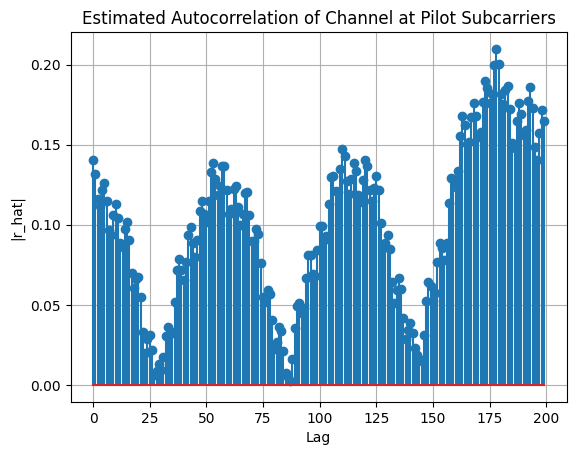

In [148]:
# Estimate the correlation bandwidth for the wiener filter
max_lag = num_pilots - 1
r_hat = np.zeros((max_lag + 1,), dtype=np.complex128)

for lag in range(0, max_lag + 1):
    for k1 in range(num_pilots):
        k2 = k1 + lag
        if k2 >= num_pilots:
            continue
        # Compute the autocorrelation at this lag
        r_hat[lag] += np.sum(np.conj(all_pilot_estimations[k1]) * all_pilot_estimations[k2])
    r_hat[lag] /= (num_pilots - lag) * frame_length * process_variance_estimate

slope, _ = np.polyfit(np.arange(0, max_lag + 1), np.abs(r_hat), 1)
correlation_bandwidth = -1 / slope if slope != 0 else np.inf

print(f'Estimated correlation bandwidth: {correlation_bandwidth}')

# Plot r_hat
plt.figure()
plt.stem(np.arange(0, max_lag + 1), np.abs(r_hat))
plt.title('Estimated Autocorrelation of Channel at Pilot Subcarriers')
plt.xlabel('Lag')
plt.ylabel('|r_hat|')
plt.grid()



In [149]:
for i in range(frame_length):
    symbols[i]['channel_estimation'] = interpolation_function(fft_size, pilot_indices, symbols[i]['pilot_channel_estimation'], **{'noise_variance': noise_variance, 'correlation_bandwidth': 11.0, 'constant': 1.2})

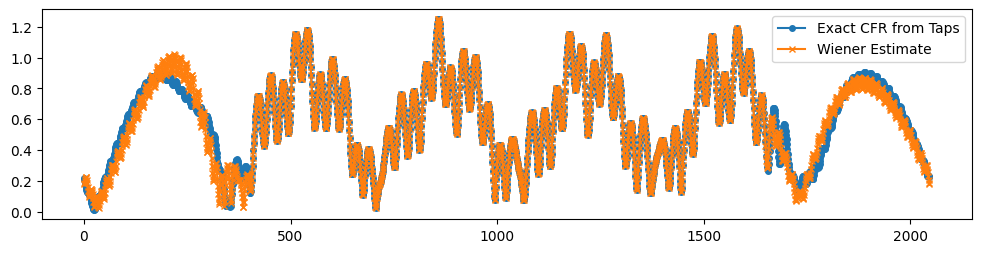

In [150]:
import numpy as np

def solve_taps_from_noiseless_pilots(Yk, pilot_idx, pilot_symbol, L, N):
    """
    Solve the channel taps h[0..L-1] exactly from noiseless pilots, if Np>=L and F has full column rank.
    Args:
        Yk:           (N,) complex ndarray, received symbol in frequency domain (after CP removal + FFT).
        pilot_idx:    (Np,) int ndarray, pilot subcarrier indices.
        pilot_symbol: complex scalar, known pilot symbol value on all pilots.
        L:            int, channel length (taps) = Ncp + 1.
        N:            int, FFT size.

    Returns:
        h:            (L,) complex ndarray, estimated taps.
        F_pL:         (Np, L) complex ndarray, partial-DFT matrix used.
        H_p:          (Np,) complex ndarray, pilot CFR values (Y/X).
    """
    # Noiseless pilot CFR samples: H[p] = Y[p]/X[p]
    H_p = Yk[pilot_idx] / pilot_symbol

    # Build partial-DFT (Vandermonde) matrix: [F_pL]_{i,ℓ} = e^{-j 2π p_i ℓ / N}
    ell = np.arange(L)
    F_pL = np.exp(-1j * 2*np.pi * (pilot_idx[:, None] * ell[None, :]) / N)

    # Solve least-squares (exact if Np>=L and F_pL full column rank)
    h, *_ = np.linalg.lstsq(F_pL, H_p, rcond=None)
    return h, F_pL, H_p

def reconstruct_cfr_from_taps(h, N):
    """
    Reconstruct full CFR H[k] = sum_{ℓ=0}^{L-1} h[ℓ] e^{-j 2π k ℓ / N}.
    Args:
        h: (L,) complex ndarray, taps.
        N: int, FFT size.

    Returns:
        H_full: (N,) complex ndarray, CFR on all subcarriers.
    """
    k = np.arange(N)[:, None]
    ell = np.arange(h.size)[None, :]
    H_full = np.exp(-1j * 2*np.pi * (k * ell) / N) @ h
    return H_full

def compare_cfrs(H_exact, H_wiener):
    """
    Simple comparison metrics between exact CFR and a candidate estimate.
    Returns RMSE and max-abs error.
    """
    diff = H_wiener - H_exact
    rmse = np.sqrt(np.mean(np.abs(diff)**2))
    maxerr = np.max(np.abs(diff))
    return rmse, maxerr

# ---------------------------
# Example usage (single OFDM symbol):
# ---------------------------
# Inputs you already have in your code:
# Yk_noiseless : (N,) complex, frequency-domain received (unitary FFT) for the NoNoise case
# pilot_idx    : (Np,) int
# pilot_symbol : complex scalar (e.g., 1+0j if normalized)
# L            : channel length (Ncp + 1)
# N            : fft_size
# H_wiener     : (N,) complex, your Wiener estimate for the same symbol

# h, F_pL, H_p = solve_taps_from_noiseless_pilots(Yk_noiseless, pilot_idx, pilot_symbol, L, N)
# H_exact = reconstruct_cfr_from_taps(h, N)
# rmse, maxerr = compare_cfrs(H_exact, H_wiener)
# print(f"Exact-vs-Wiener: RMSE={rmse:.3e}, max|err|={maxerr:.3e}")

# If Np >= L and F_pL has full column rank, H_exact should be numerically exact at all k (NoNoise).
# You can check rank like this:
# rank = np.linalg.matrix_rank(F_pL)
# print(f"rank(F_pL)={rank} (need {L} for exact solvability)")

h, _, _ = solve_taps_from_noiseless_pilots(np.array(symbols[0]['fft']), pilot_indices, pilot_symbol, channel_length, fft_size)
H_full = reconstruct_cfr_from_taps(h, fft_size)
H_wiener = symbols[0]['channel_estimation']

# Plot both CFRs in one plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.abs(H_full), label='Exact CFR from Taps', linestyle='-', marker='o', markersize=4)
plt.plot(np.abs(H_wiener), label='Wiener Estimate', linestyle='-', marker='x', markersize=4)
plt.legend()


import numpy as np

def wiener_fir_subspace(fft_size, pilot_indices, pilot_cfr, L, noise_variance=0.0, gamma=1.0):
    """
    FIR-subspace Wiener/MMSE channel estimator (exact in noiseless case if Np>=L and full rank).
    Args:
        fft_size       : N
        pilot_indices  : array of pilot subcarrier indices, shape (Np,)
        pilot_cfr      : noisy CFR at pilots, i.e., H_hat_p = Y[p]/X[p], shape (Np,)
        L              : channel length (taps) = Ncp + 1
        noise_variance : variance of noise on H_hat_p (sigma_n^2 / |X|^2), after unitary FFT
        gamma          : prior tap power (any positive scalar; only relative to noise matters)

    Returns:
        H_hat_full     : estimated CFR on all N subcarriers, shape (N,)
    """
    N = fft_size
    P = np.asarray(pilot_indices, dtype=int)
    Np = P.size

    # Build Φ_X (N x L) and Φ_P (Np x L)
    ell = np.arange(L)[None, :]               # (1, L)
    k_all = np.arange(N)[:, None]             # (N, 1)
    k_pil = P[:, None]                        # (Np, 1)

    Phi_X = np.exp(-1j * 2*np.pi * (k_all @ ell) / N)   # (N, L)
    Phi_P = np.exp(-1j * 2*np.pi * (k_pil @ ell) / N)   # (Np, L)

    # Build covariances for Wiener
    R_xp = gamma * (Phi_X @ Phi_P.conj().T)             # (N, Np)
    R_pp = gamma * (Phi_P @ Phi_P.conj().T)             # (Np, Np)

    # Solve (R_pp + sigma^2 I) alpha = pilot_cfr
    A = R_pp + noise_variance * np.eye(Np)
    try:
        alpha = np.linalg.solve(A, pilot_cfr)           # (Np,)
    except np.linalg.LinAlgError:
        alpha = np.linalg.pinv(A) @ pilot_cfr

    H_hat_full = R_xp @ alpha                           # (N,)
    return H_hat_full


In [151]:
for i in range(frame_length):
    symbols[i]['H_from_taps'] = wiener_fir_subspace(fft_size, pilot_indices, symbols[i]['pilot_channel_estimation'], channel_length, noise_variance, gamma=1.0)
    
print(channel_length)

161


In [152]:
# Retrieve the transmitted data symbols
for i in range(frame_length):
    symbols[i]['qpsk_estimation'] = equalizer_function(symbols[i]['fft'][data_indices], symbols[i]['H_from_taps'][data_indices], noise_variance)

In [153]:
# As the image only need 110*110 / 2 = 6050 samples, we discard, the last 950 samples
all_samples = np.concatenate([symbols[i]['qpsk_estimation'] for i in range(frame_length)]).flatten()[:image_size[0] * image_size[1] // 2]

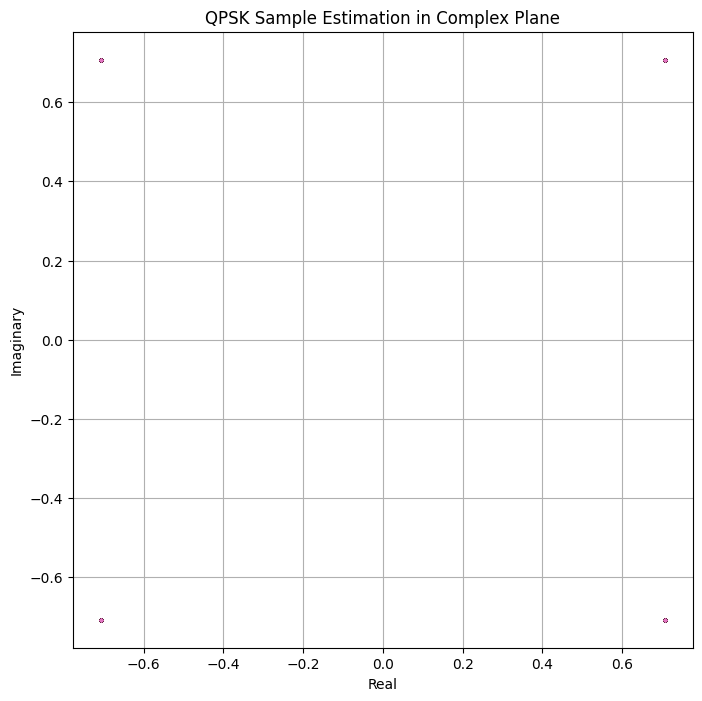

In [154]:
# Plot all QPSK samples as little dots in the complex plane

plt.figure(figsize=(8, 8))
for i in range(frame_length):
    plt.scatter(all_samples.real, all_samples.imag, s=2, alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('QPSK Sample Estimation in Complex Plane')
plt.grid(True)

In [155]:
def calculate_mse(qpsk_estimations: np.array, true_symbols: np.array) -> float:
    ''' 
    Calculate Mean Squared Error between estimated and true symbols

    :param np.array qpsk_estimations: Estimated QPSK symbols
    :param np.array true_symbols: True QPSK symbols

    :return float: Mean Squared Error
    '''
    
    errors = qpsk_estimations - true_symbols
    return np.mean(np.abs(errors)**2)

In [156]:
# Decode the samples to bits using a QPSK Demapper
image_bits = []
for sample in all_samples:
    imag_sign = int(np.sign(sample.imag))
    real_sign = int(np.sign(sample.real))

    image_bits.extend([(1 - imag_sign) // 2, (1 - real_sign) // 2])

In [ ]:
if False:
    np.savetxt('recovered_signals/recovered_signal_dataset3.txt', all_samples)

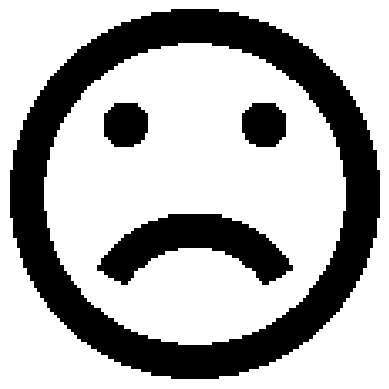

In [158]:
# Reshape the bit sequence to the original image size
image = (255 * np.reshape(np.array(image_bits), tuple(image_size))).astype(np.uint8).T
plt.imshow(image, cmap='gray')   # use 'gray' if it’s a grayscale image
plt.axis('off')
plt.show()    

In [159]:
# Load reconstructed image and display it
reconstructed_image = np.loadtxt('reconstructed_image.txt', dtype=np.uint8) * 255
plt.figure()
plt.imshow(reconstructed_image, cmap='gray')

FileNotFoundError: reconstructed_image.txt not found.

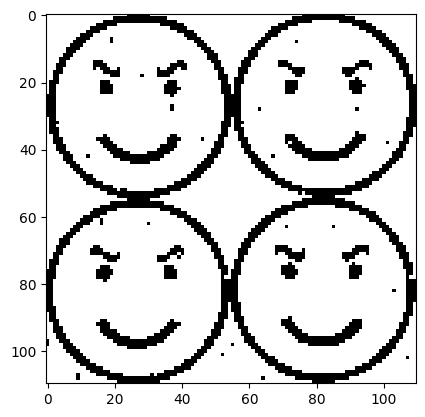

In [ ]:
qpsk = np.loadtxt('recovered_signals/recovered_signal_dataset2.txt', dtype=np.complex128)
bits = np.array([(1 - int(np.sign(sample.imag))) // 2 for sample in qpsk] + [(1 - int(np.sign(sample.real))) // 2 for sample in qpsk]).flatten()

plt.imshow(np.reshape(bits, (110, 110)), cmap='gray')

In [ ]:
equalized = equalizer_function(symbols[0]['fft'][data_indices], H_full[data_indices], noise_variance)


plt.scatter(equalized.real, equalized.imag, s=10, alpha=0.7)
plt.xlabel('Real')
plt.ylabel('Imaginary')


In [ ]:
a = np.arange(2048)
b = np.atleast_2d(np.arange(160)).T

print((a * b).shape)

In [ ]:
def my_wiener(fft_size: int, pilot_indices: np.array, pilot_channel_estimation: np.array, L) -> np.array:
    ell = np.arange(L)[None, :]
    subcarrier_idx = np.arange(fft_size)[:, None]
    pilot_idx = pilot_indices[:, None]
    
    phiX = np.exp(-1j * 2 * np.pi * (subcarrier_idx @ ell) / fft_size)
    phiP = np.exp(-1j * 2 * np.pi * (pilot_idx @ ell) / fft_size)
    
    R_pp = phiP @ phiP.conj().T
    R_xp = phiX @ phiP.conj().T
    
    print('Mine')
    print(R_xp[0][:10])
    print(R_pp[0][:10])
    
    sigma2 = 0# kwargs.get('noise_variance')
    try:
        inv_term = np.linalg.inv(R_pp + sigma2 * np.eye(R_pp.shape[0]))
    except np.linalg.LinAlgError:
        inv_term = np.linalg.pinv(R_pp + sigma2 * np.eye(R_pp.shape[0]))

    return R_xp @ (inv_term @ pilot_channel_estimation)

def their_wiener(fft_size, pilot_indices, pilot_cfr, L):
    N = fft_size
    P = np.asarray(pilot_indices, dtype=int)
    Np = P.size

    # Build Φ_X (N x L) and Φ_P (Np x L)
    ell = np.arange(L)[None, :]               # (1, L)
    k_all = np.arange(N)[:, None]             # (N, 1)
    k_pil = P[:, None]                        # (Np, 1)

    Phi_X = np.exp(-1j * 2*np.pi * (k_all @ ell) / N)   # (N, L)
    Phi_P = np.exp(-1j * 2*np.pi * (k_pil @ ell) / N)   # (Np, L)

    # Build covariances for Wiener
    R_xp = (Phi_X @ Phi_P.conj().T)             # (N, Np)
    R_pp = (Phi_P @ Phi_P.conj().T)             # (Np, Np)
    
    print('Their')
    print(R_xp[0][:10])
    print(R_pp[0][:10])

    # Solve (R_pp + sigma^2 I) alpha = pilot_cfr
    A = R_pp
    try:
        alpha = np.linalg.solve(A, pilot_cfr)           # (Np,)
    except np.linalg.LinAlgError:
        alpha = np.linalg.pinv(A) @ pilot_cfr

    H_hat_full = R_xp @ alpha                           # (N,)
    return H_hat_full

my_wiener(fft_size, pilot_indices, symbols[0]['pilot_channel_estimation'], channel_length)
their_wiener(fft_size, pilot_indices, symbols[0]['pilot_channel_estimation'], channel_length)

Mine
[ 1.31823664+5.46031493e-01j -0.27394398+9.03072280e-01j
  1.20404389+2.39499220e-01j -0.11150792+1.13215896e+00j
  1.        -1.37905758e-14j  0.12626037+1.28194301e+00j
  0.73734989-1.46668012e-01j  0.40430484+1.33281445e+00j
  0.45371431-1.87934623e-01j  0.68374529+1.27919747e+00j]
[161.        +1.01465364e-17j  10.60756784+1.07700444e+02j
  -9.43150331+1.87604265e+00j  10.14213845+3.34341498e+01j
  -8.7454815 +3.62249705e+00j   9.24973528+1.73050375e+01j
  -7.66509518+5.12165286e+00j   8.00349892+9.75229165e+00j
  -6.27833462+6.27833462e+00j   6.50411505+5.33778928e+00j]
Their
[ 1.31823664+5.46031493e-01j -0.27394398+9.03072280e-01j
  1.20404389+2.39499220e-01j -0.11150792+1.13215896e+00j
  1.        -1.37905758e-14j  0.12626037+1.28194301e+00j
  0.73734989-1.46668012e-01j  0.40430484+1.33281445e+00j
  0.45371431-1.87934623e-01j  0.68374529+1.27919747e+00j]
[161.        +1.01465364e-17j  10.60756784+1.07700444e+02j
  -9.43150331+1.87604265e+00j  10.14213845+3.34341498e+01j
  -

array([0.06035026+0.13703383j, 0.0560138 +0.13326781j,
       0.05183605+0.13246293j, ..., 0.06210632+0.16095832j,
       0.06426571+0.15191464j, 0.06347317+0.1435257j ], shape=(2048,))

Estimated gamma: 0.13406196267746243


In [178]:
all_pilot_estimations = np.array([symbol['pilot_channel_estimation'] for symbol in symbols]).flatten()
mean_pilot_power = np.mean(np.abs(all_pilot_estimations)**2)           # average over time and pilots
sigmaH2_hat = mean_pilot_power - noise_variance # de-bias for pilot noise
gamma_hat = fft_size * max(sigmaH2_hat, 0.0) / channel_length
print(f'Estimated gamma: {gamma_hat}')

Estimated gamma: 6.317580837132307


In [197]:
pilot_estimations = symbols[0]['pilot_channel_estimation']

R_HH = 1 / len(pilot_estimations) * (pilot_estimations[:, None] @ pilot_estimations[None, :].conj())

print(R_HH)

ell = np.arange(channel_length)[None, :]
pilot_idx = pilot_indices[:, None]

phiP = np.exp(-1j * 2 * np.pi * (pilot_idx @ ell) / fft_size)
phiP_inv = np.linalg.pinv(phiP)


gammaI = phiP_inv @ (R_HH @ phiP_inv.conj().T)
print(np.trace(gammaI))
# Set all entries to zero which are smaller than 0.01
gammaI[np.abs(gammaI) < 0.001] = 0
np.savetxt('gammaI.txt', gammaI.view(float).reshape(gammaI.shape[0], -1))

[[ 2.72797582e-03+0.j          2.04781182e-03+0.00062923j
   1.57203678e-03+0.0001526j  ...  7.66901289e-04+0.00367175j
  -3.60080952e-04+0.00370817j -1.03178072e-03+0.00267457j]
 [ 2.04781182e-03-0.00062923j  1.68236923e-03+0.j
   1.21527983e-03-0.00024805j ...  1.42260760e-03+0.00257938j
   5.85015351e-04+0.00286667j -1.57616336e-04+0.00224571j]
 [ 1.57203678e-03-0.0001526j   1.21527983e-03+0.00024805j
   9.14445600e-04+0.j         ...  6.47327737e-04+0.002073j
  -7.53785086e-08+0.00215703j -4.44969298e-04+0.00159898j]
 ...
 [ 7.66901289e-04-0.00367175j  1.42260760e-03-0.00257938j
   6.47327737e-04-0.002073j   ...  5.15761712e-03+0.j
   4.88981367e-03+0.00152711j  3.30980834e-03+0.00214062j]
 [-3.60080952e-04-0.00370817j  5.85015351e-04-0.00286667j
  -7.53785086e-08-0.00215703j ...  4.88981367e-03-0.00152711j
   5.08807569e-03+0.j          3.77176438e-03+0.00104948j]
 [-1.03178072e-03-0.00267457j -1.57616336e-04-0.00224571j
  -4.44969298e-04-0.00159898j ...  3.30980834e-03-0.00214062

In [198]:
import numpy as np

def build_phi_p(pilot_idx, L, N):
    p = np.asarray(pilot_idx)[:, None]     # (Np,1)
    ell = np.arange(L)[None, :]            # (1,L)
    Phi_P = np.exp(-1j * 2*np.pi * (p * ell) / N)  # (Np, L)
    return Phi_P


In [199]:
def gamma_from_pilot_cov_noiseless(Hp_symbols, pilot_idx, L, N):
    """
    Hp_symbols: array [T, Np] of *true/NoNoise* CFR on pilot bins (i.e., Y/X with σ²=0)
    """
    T, Np = Hp_symbols.shape
    # Sample covariance on pilots
    Rpp_hat = (Hp_symbols.conj().T @ Hp_symbols) / T   # (Np,Np)

    Phi_P = build_phi_p(pilot_idx, L, N)
    # Left pseudoinverse (needs Np >= L and full column rank)
    Phi_dag = np.linalg.pinv(Phi_P)                    # (L,Np)

    # Back-project to tap space
    C_h_hat = Phi_dag @ Rpp_hat @ Phi_dag.conj().T     # (L,L)

    # White-tap gamma (or take diag for PDP)
    gamma_hat = float(np.real(np.trace(C_h_hat)) / L)
    return gamma_hat, C_h_hat


In [201]:
print(gamma_from_pilot_cov_noiseless(np.array([symbols[0]['pilot_channel_estimation']]), pilot_indices, channel_length, fft_size))

(1.533903345895517e+25, array([[1.40283604e+09-4.17232513e-07j, 2.79302219e+10+3.55836351e+08j,
        2.90082893e+11+6.30581508e+09j, ...,
        1.96811117e+10+1.31058694e+10j, 1.65921529e+09+1.43295198e+09j,
        7.00949112e+07+7.70416189e+07j],
       [2.79302219e+10-3.55836351e+08j, 5.56176127e+11-3.05175781e-05j,
        5.77709952e+12+5.19667121e+10j, ...,
        3.95171884e+11+2.55943372e+11j, 3.33981636e+10+2.81089569e+10j,
        1.41511950e+09+1.51610533e+09j],
       [2.90082893e+11-6.30581508e+09j, 5.77709952e+12-5.19667121e+10j,
        6.00126071e+13-7.22656250e-02j, ...,
        4.12863430e+12+2.62160577e+12j, 3.49538996e+11+2.88852111e+11j,
        1.48407542e+10+1.56158307e+10j],
       ...,
       [1.96811117e+10-1.31058694e+10j, 3.95171884e+11-2.55943372e+11j,
        4.12863430e+12-2.62160577e+12j, ...,
        3.98556890e+11+2.80761719e-03j, 3.66652135e+10+4.60255435e+09j,
        1.70315212e+09+4.26001283e+08j],
       [1.65921529e+09-1.43295198e+09j, 3.33

In [ ]:
build_phi_p(pilot_indices, channel_length, fft_size)
np.linalg.matrix_rank(build_phi_p(pilot_indices, channel_length, fft_size))


np.int64(120)